# Run the Imports and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cv2 import fastNlMeansDenoising
import pywt
from skimage.io import imread, imsave
from skimage.util import img_as_float64
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from src.noiseDist import addNoise
from src.thresholdingMethod import applyShrink
from src.utilities import get_sigma_est, mse, gaussianSmoothing, medianSmoothing, calculate_ssim

In [2]:
def denoising(image, wavelet = 'db4', level = 4, mode = 'sure'):
    N = image.size
    coeffs = pywt.wavedec2(image, wavelet = wavelet, level = level)
    sigma_est = get_sigma_est(coeffs)
    thresholded_details = applyShrink(coeffs, sigma_est, N,  mode = mode)
    denoised_img = pywt.waverec2(thresholded_details, wavelet = wavelet)
    return denoised_img

# Input Image and Parameters

In [3]:
image_label = {0: 'cameraman',      1: 'house', 
               2: 'jetplane',       3: 'lake', 
               4: 'lena',           5: 'livingroom', 
               6: 'mandril',        7: 'peppers', 
               8: 'pirate',         9: 'walkbridge', 
               10: 'woman_blonde',  11: 'woman_darkhair'}

# Write the Index for the image
image_idx = 0

In [4]:
img = imread('dataset/' + image_label[image_idx] + '.tif')
img_float = img_as_float64(img)
img.shape

(512, 512)

In [88]:
# Parameters
# mode = gaussian      sigma = Low: 15             Moderate:  25             High: 50
# mode = s&p          amount = Low: 0.05           Moderate: 0.1             High: 0.2
# mode = uniform   low, high = Low: (-0.1, 0.1)    Moderate: (-0.2, 0.2)     High: (-0.5, 0.5)

gaussian_sigma = 25
sp_noise_amt = 0.05
uni_low, uni_high = -0.1, 0.1
noise_mode = 'uniform'

wavelet_level = 1
wavelet_type = 'haar'
mode = ['visu', 'sure', 'bayes']

# Process

In [89]:
noisy_img = addNoise(img_float, mode = noise_mode, mean = 0, sigma = gaussian_sigma, amount = sp_noise_amt, low = uni_low, high = uni_high)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

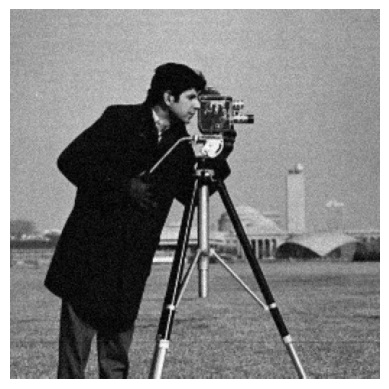

In [93]:
denoised_img, t = denoising(noisy_img, wavelet_type, wavelet_level, 'bayes')
denoised_img_lib = gaussianSmoothing(noisy_img, 7, 25)
plt.imshow(denoised_img, cmap = "gray")
plt.axis("off")

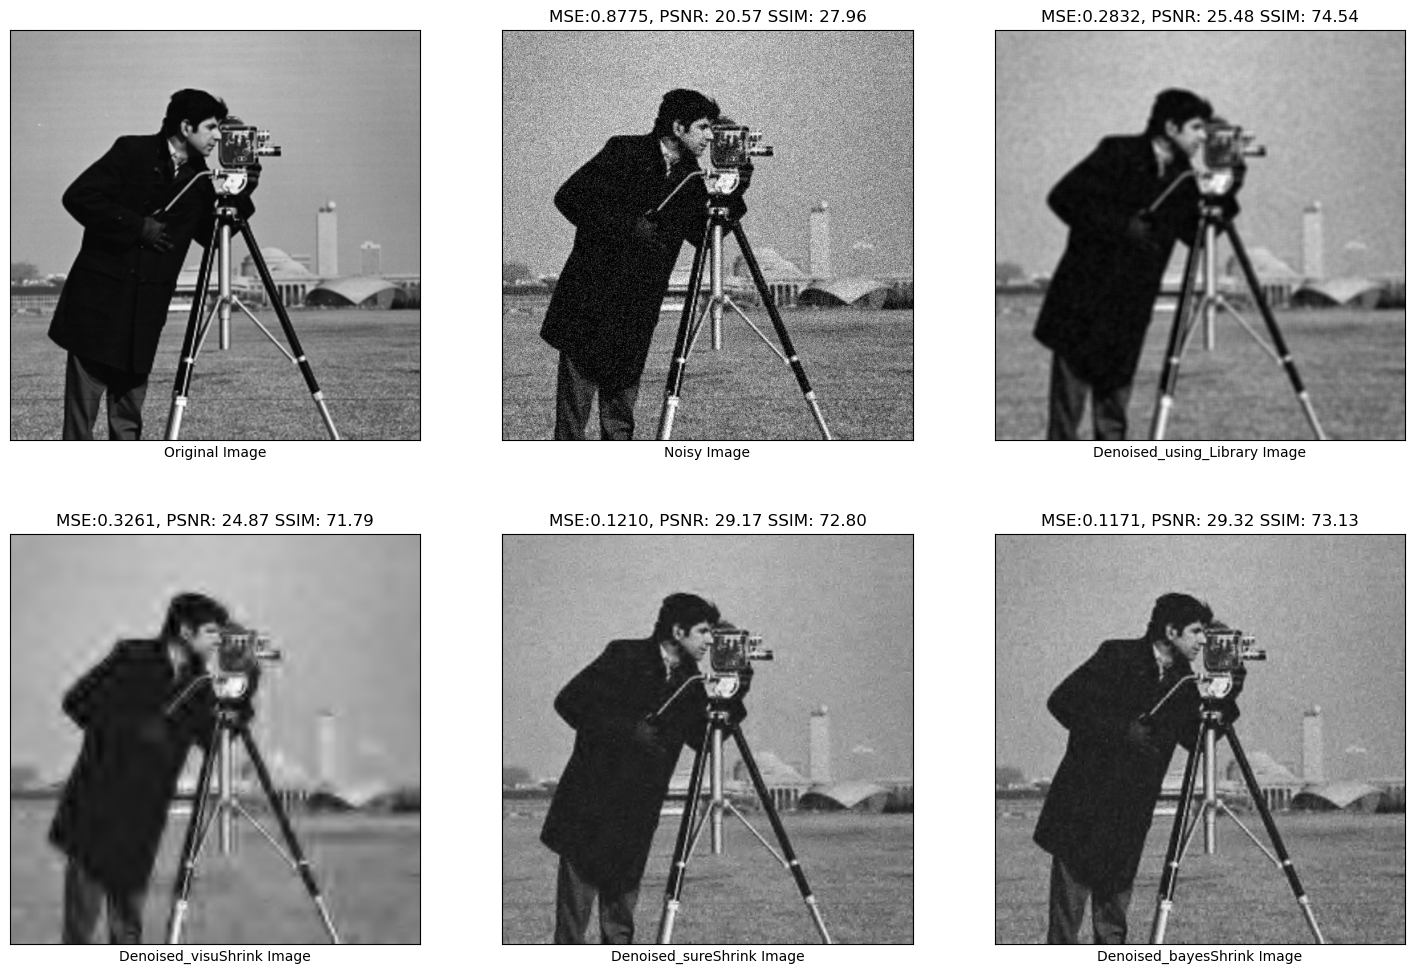

In [ ]:

denoised_img_lib = gaussianSmoothing(noisy_img, 7, 25)
# denoised_img_lib = img_as_float64(fastNlMeansDenoising((noisy_img * 255).astype(np.uint8), None, 20))

fig,axes = plt.subplots(nrows=2, ncols=3, figsize=(18,12))
axes[0, 0].imshow(img_float, cmap='gray')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].set_xlabel("Original Image")

MSE = mse(img_float, noisy_img) * 100
SSIM = calculate_ssim(img_float, noisy_img) * 100
PSNR = psnr(img_float, noisy_img)
axes[0, 1].imshow(noisy_img, cmap='gray')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 1].set_title(f"""MSE:{MSE:.4f}, PSNR: {PSNR:.2f} SSIM: {SSIM:.2f}""")
axes[0, 1].set_xlabel("Noisy Image")


MSE = mse(img_float, denoised_img_lib) * 100
SSIM = calculate_ssim(img_float, denoised_img_lib) * 100
PSNR = psnr(img_float, denoised_img_lib)
axes[0, 2].imshow(denoised_img_lib, cmap='gray')
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])
# axes[0, 2].set_title(f"""MSE:{MSE:.4f}, PSNR: {PSNR:.2f} SSIM: {SSIM:.2f}""")
axes[0, 2].set_xlabel("Denoised_using_Library Image")

for i in range(len(mode)):
    denoised_img = denoising(noisy_img, wavelet_type, wavelet_level, mode[i])

    MSE = mse(img_float, denoised_img) * 100
    SSIM = calculate_ssim(img_float, denoised_img) * 100
    PSNR = psnr(img_float, denoised_img)
    axes[1, i].imshow(denoised_img, cmap='gray')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    axes[1, i].set_title(f"""MSE:{MSE:.4f}, PSNR: {PSNR:.2f} SSIM: {SSIM:.2f}""")
    axes[1, i].set_xlabel(f"""Denoised_{mode[i]}Shrink Image""")


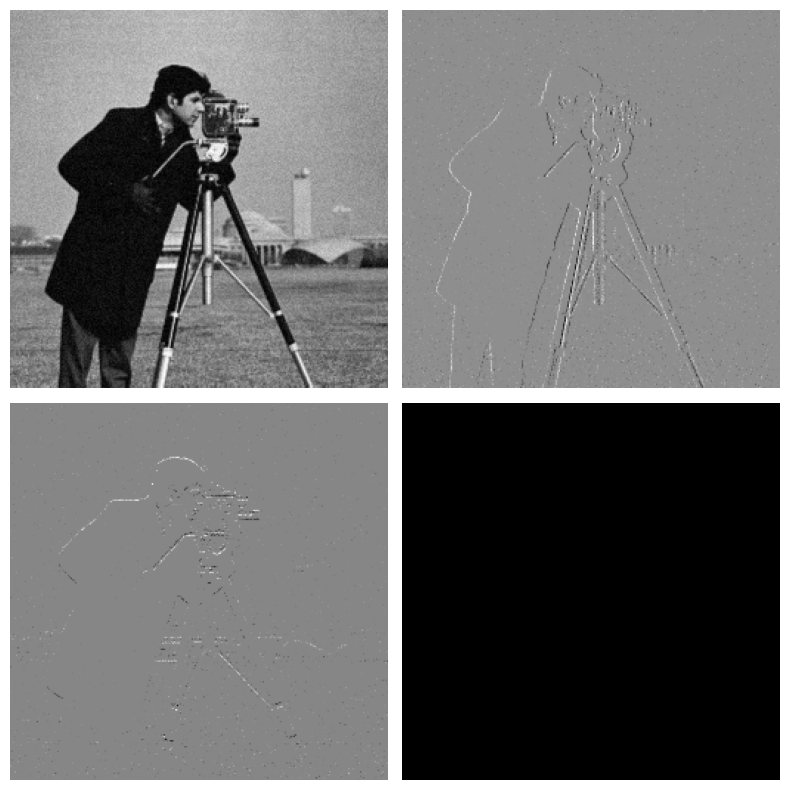

In [91]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(t[0], cmap='gray')
axs[0, 0].axis('off')

axs[0, 1].imshow(t[1][1], cmap='gray')
axs[0, 1].axis('off')

axs[1, 0].imshow(t[1][0], cmap='gray')
axs[1, 0].axis('off')

axs[1, 1].imshow(t[1][2], cmap='gray')
axs[1, 1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

In [4]:
noise_mode_list = ['gaussian', 's&p', 'uniform']     #For main Stats
wavelet_type_list = ['db4', 'haar']           # For main Stats
mode_list = ['visu', 'sure', 'bayes']
level = 4
gaussian_sigma = 25
sp_noise_amt = 0.05
uni_low, uni_high = -0.1, 0.1
noise_mode = 'gaussian'

stats = {}
for noise_mode in noise_mode_list:
    stats[noise_mode] = {}
    for image_idx, image_name in image_label.items():
        
        img_float = img_as_float64(imread('dataset/' + image_name + '.tif'))
        noisy_img = addNoise(img_float, mode = noise_mode, mean = 0, sigma = gaussian_sigma, amount = sp_noise_amt, low = uni_low, high = uni_high)
        stats[noise_mode][image_name] = {'noisy_img': {'SSIM': calculate_ssim(img_float, noisy_img) * 100, 'PSNR': psnr(img_float, noisy_img), "MSE": mse(img_float, noisy_img) * 100}}
        
        if noise_mode == 's&p':
            denoised_img_lib = medianSmoothing(noisy_img, 5)
        else:
            denoised_img_lib = gaussianSmoothing(noisy_img, 5, 25)
        stats[noise_mode][image_name]['denoised_lib'] = {'SSIM': calculate_ssim(img_float, denoised_img_lib) * 100, 'PSNR': psnr(img_float, denoised_img_lib), "MSE": mse(img_float, denoised_img_lib) * 100}


        for wavelet_type in wavelet_type_list:
            stats[noise_mode][image_name][wavelet_type] = {}
            for mode in mode_list:
                denoised_img = denoising(noisy_img, wavelet = wavelet_type, level = level, mode = mode)
                MSE = mse(img_float, denoised_img) * 100
                SSIM = calculate_ssim(img_float, denoised_img) * 100
                PSNR = psnr(img_float, denoised_img)
                stats[noise_mode][image_name][wavelet_type][mode] = {'SSIM': SSIM, 'PSNR': PSNR, "MSE": MSE}


In [ ]:
# # Plotting Wavelet Coefficients
# fig,axes = plt.subplots(nrows=level, ncols=3, figsize=(15,20))
# for i in range(1, level + 1):
#     axes[0].imshow(coeffs[i][0], cmap='gray')
#     axes[0].axis('off')
#     axes[0].set_title(f"""LH Coeff: {i}""")

#     axes[1].imshow(coeffs[i][1], cmap='gray')
#     axes[1].axis('off')
#     axes[1].set_title(f"""HL Coeff: {i}""")

#     axes[2].imshow(coeffs[i][2], cmap='gray')
#     axes[2].axis('off')
#     axes[2].set_title(f"""HH Coeff: {i}""")


In [7]:
import pickle
with open("Result.pkl", "rb") as file:
    stats = pickle.load(file)

In [23]:
D = {'bayes': [], 'sure': []}
N = []
DS = []
noise_mode = 'uniform'
for image_idx, image_name in image_label.items():
    N.append(stats[noise_mode][image_name]['noisy_img']['SSIM'])
    DS.append(stats[noise_mode][image_name]['denoised_lib']['SSIM'])
    D['bayes'].append(stats[noise_mode][image_name]['db4']['bayes']['SSIM'])
    D['sure'].append(stats[noise_mode][image_name]['db4']['sure']['SSIM'])

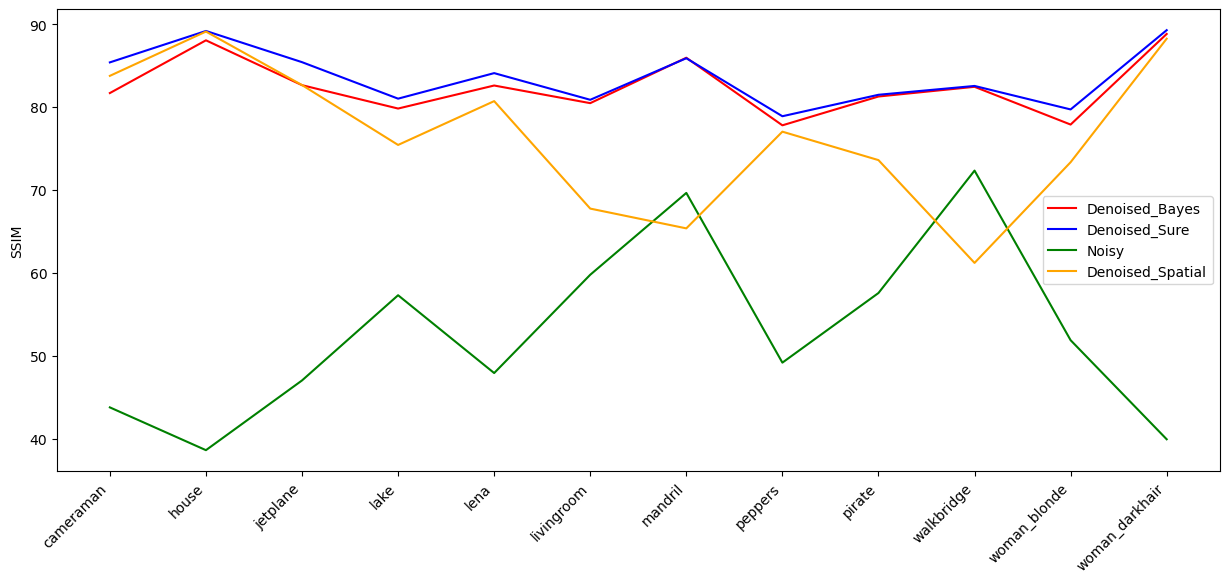

In [24]:
name = image_label.values()
plt.figure(figsize=(15, 6))
plt.plot(name, D['bayes'], color='red', linestyle='-', label='Denoised_Bayes')
plt.plot(name, D['sure'], color='blue', linestyle='-', label='Denoised_Sure')
plt.plot(name, N, color='green', linestyle='-', label='Noisy')
plt.plot(name, DS, color='orange', linestyle='-', label='Denoised_Spatial')
plt.xticks(rotation=45, ha='right')
plt.ylabel('SSIM')
plt.legend()
# plt.grid(True)
plt.show()